# store geostrophic fields

Xiaolong initial [notebook](https://github.com/xy6g13/equinox_working/blob/master/sandbox/Reconstruction/Geostrophy%20metric.ipynb)

In [1]:
import os, sys, shutil
import numpy as np
import dask
import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

import xgcm

from mitequinox.utils import *
from mitequinox.dynamic import *
from mitequinox.plot import *

In [2]:
from dask_jobqueue import PBSCluster
#cluster = PBSCluster(cores=12, walltime='12:00:00')
cluster = PBSCluster(cores=12, walltime='01:00:00')
w = cluster.scale(60*12)
#w = cluster.scale(1*12)
#w = cluster.scale(5) # postprocessing

/home/mp/pontea/.conda/envs/equinox/lib/python3.7/site-packages/distributed/dashboard/core.py:74: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
cluster

In [5]:
client

Client Scheduler: tcp://10.135.39.59:47389 Dashboard: http://10.135.39.59:60778/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


/home/mp/pontea/.conda/envs/equinox/lib/python3.7/site-packages/distributed/scheduler.py:313: UserWarning: WorkerState.ncores has moved to WorkerState.nthreads
  warnings.warn("WorkerState.ncores has moved to WorkerState.nthreads")


---
# load data


In [6]:
grd = load_grd().drop(['hFacC','hFacW','hFacS','rA','rAw','rAs'])

dsU = xr.open_zarr(root_data_dir+'zarr/%s.zarr'%('SSU'))
dsV = xr.open_zarr(root_data_dir+'zarr/%s.zarr'%('SSV'))
dsE = xr.open_zarr(root_data_dir+'zarr/%s.zarr'%('Eta'))

ds = (xr.merge([dsU,dsV, dsE], join='inner')
      .assign_coords(**grd.variables))
grid = xgcm.Grid(ds, periodic=['X', 'Y'])

# add coriolis parameters to dataset
#omega = 7.3/100000 # XY, 
# see, http://mitgcm.org/public/r2_manual/final/code_reference/vdb/names/R.htm
f = 2*omega_earth*np.sin(np.deg2rad(ds['YG'])) # at vorticity points
f_i = grid.interp(f,'X').chunk({'i':None}) # at v points
f_j = grid.interp(f,'Y').chunk({'j':None}) # at u points
ds0 = ds.assign_coords(f=f,f_i=f_i,f_j=f_j)

---

## start computing and storing

is the storing really necessary?

In [7]:
terms = ['u_coriolis_linear','u_gradp', 'v_coriolis_linear','v_gradp']
terms = ['v_coriolis_linear']

In [8]:
#Nt, Ni, Nj = 24*20, 188, 96
Nt, Ni, Nj = 24*40, 376, 188

/home/mp/pontea/.conda/envs/equinox/lib/python3.7/site-packages/distributed/scheduler.py:313: UserWarning: WorkerState.ncores has moved to WorkerState.nthreads
  warnings.warn("WorkerState.ncores has moved to WorkerState.nthreads")


In [9]:
overwrite=True

for face in range(11,12):

    print('--- start processing face %d'%face)
    ds = ds0.sel(face=face)

    for t in terms:
        
        bterm = get_mbal(t, ds, grid)

        if t[0]=='u':
            chunks = {'time': Nt, 'i_g': Ni, 'j': Nj}
        elif t[0]=='v':
            chunks = {'time': Nt, 'i': Ni, 'j_g': Nj}
        bterm = bterm.isel(time=slice(len(ds.time)//Nt *Nt))
        bterm = bterm.chunk(chunks)

        file_out = work_data_dir+'mbal/%s_f%02d.zarr'%(t,face)
        if not os.path.isdir(file_out) or overwrite:
            bterm.to_dataset().to_zarr(file_out, mode='w')
        print('  %s, face=%d - processed'%(t, face))

print('mbal terms computed for face=%d'%(face))

--- start processing face 11
  v_coriolis_linear, face=11 - processed
mbal terms computed for face=11


In [11]:
cluster.close()

---

## check result

In [15]:
#t = terms[0]
#face = 1
for face in range(13):
    t = terms[0]
    #for t in terms:
    ds = xr.open_zarr(work_data_dir+'mbal/%s_f%02d.zarr'%(t,face))
    print(np.abs(ds[t]).mean().values)
    #print(ds)
    print('face = %d, term = %s'%(face,t))

8.808109e-06
face = 0, term = u_coriolis_linear
1.1890352e-05
face = 1, term = u_coriolis_linear
1.6254831e-05
face = 2, term = u_coriolis_linear
1.42116005e-05
face = 3, term = u_coriolis_linear
1.1237888e-05
face = 4, term = u_coriolis_linear
1.2675767e-05
face = 5, term = u_coriolis_linear
8.593417e-06
face = 6, term = u_coriolis_linear
1.4433777e-05
face = 7, term = u_coriolis_linear
1.1593577e-05
face = 8, term = u_coriolis_linear
1.353924e-05
face = 9, term = u_coriolis_linear
1.5262634e-05
face = 10, term = u_coriolis_linear
1.2627581e-05
face = 11, term = u_coriolis_linear
1.605496e-05
face = 12, term = u_coriolis_linear


In [8]:
face=1
t = terms[0]
ds = xr.open_zarr(work_data_dir+'mbal/%s_f%02d.zarr'%(t,face))

In [11]:
ds

<xarray.Dataset>
Dimensions:            (i_g: 4320, j: 4320, time: 8640)
Coordinates:
    dxC                (j, i_g) float32 dask.array<shape=(4320, 4320), chunksize=(188, 376)>
    dyG                (j, i_g) float32 dask.array<shape=(4320, 4320), chunksize=(188, 376)>
    f_j                (j, i_g) float32 dask.array<shape=(4320, 4320), chunksize=(188, 376)>
    face               int64 ...
  * i_g                (i_g) int64 0 1 2 3 4 5 ... 4314 4315 4316 4317 4318 4319
  * j                  (j) int64 0 1 2 3 4 5 6 ... 4314 4315 4316 4317 4318 4319
  * time               (time) float64 5.702e+06 5.706e+06 ... 3.68e+07 3.68e+07
Data variables:
    u_coriolis_linear  (j, i_g, time) float32 dask.array<shape=(4320, 4320, 8640), chunksize=(188, 376, 960)>

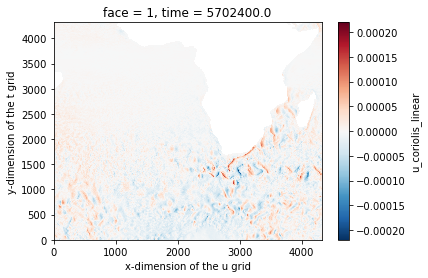

In [12]:
ds[t].isel(time=0).plot()

---

In [17]:
w = cluster.scale_up(30)

In [ ]:
client.restart()

In [16]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
